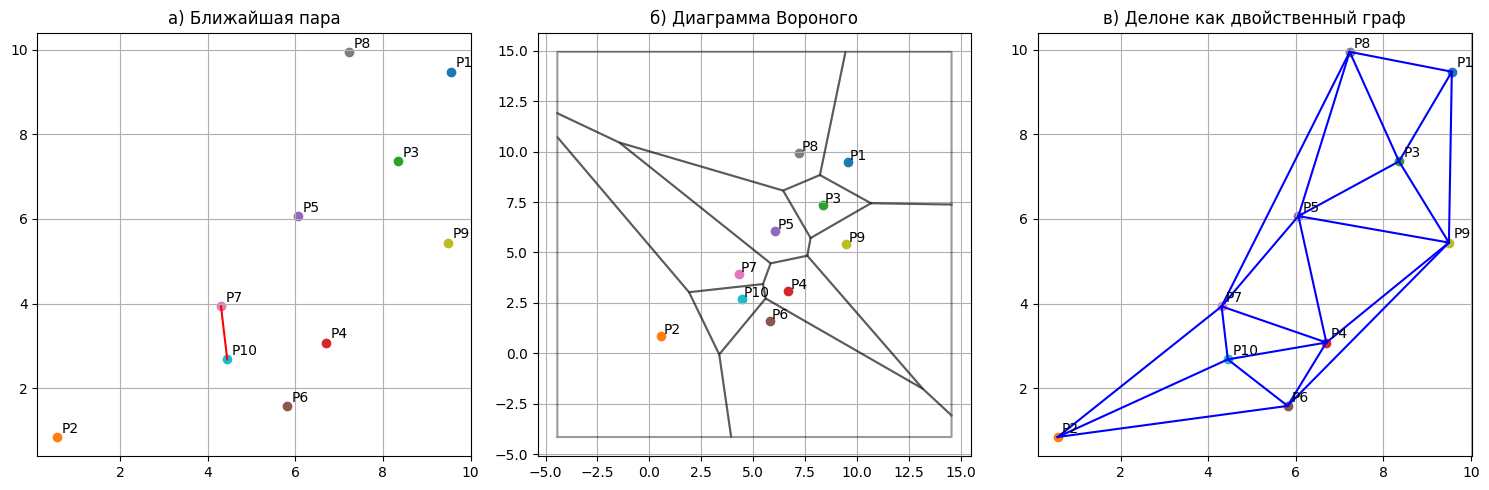

In [14]:
# --------------------------- импорт --------------------------------
import random, math
import matplotlib.pyplot as plt
from collections import Counter

# --------------------- генерация исходных точек --------------------
random.seed(2)
E = [(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(10)]

# --------------------  a) ближайшая пара --------------
def dist(p, q): return math.hypot(p[0]-q[0], p[1]-q[1])
i_min, j_min, d_min = None, None, float('inf')
for i in range(len(E)):
    for j in range(i+1, len(E)):
        d = dist(E[i], E[j])
        if d < d_min:
            i_min, j_min, d_min = i, j, d

# --------------------  b) диаграмма Вороного ----------
def is_left(a, b, c):
    return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])

def perp_bisector(p, q):
    mid = ((p[0]+q[0])/2, (p[1]+q[1])/2)
    dx, dy = q[0]-p[0], q[1]-p[1]
    return mid, (mid[0]-dy, mid[1]+dx)

def line_xsect(p1, p2, p3, p4):
    den = (p4[1]-p3[1])*(p2[0]-p1[0]) - (p4[0]-p3[0])*(p2[1]-p1[1])
    if abs(den) < 1e-9: return None
    ua = ((p4[0]-p3[0])*(p1[1]-p3[1]) - (p4[1]-p3[1])*(p1[0]-p3[0])) / den
    return (p1[0]+ua*(p2[0]-p1[0]), p1[1]+ua*(p2[1]-p1[1]))

def clip(poly, a, b, keep):
    out=[]; n=len(poly)
    for i in range(n):
        P,Q = poly[i], poly[(i+1)%n]
        inP = is_left(a,b,P)*is_left(a,b,keep) >= 0
        inQ = is_left(a,b,Q)*is_left(a,b,keep) >= 0
        if inP: out.append(P)
        if inP^inQ:
            I=line_xsect(P,Q,a,b)
            if I: out.append(I)
    return out

def voronoi_regions(pts):
    minx=min(p[0] for p in pts)-5; maxx=max(p[0] for p in pts)+5
    miny=min(p[1] for p in pts)-5; maxy=max(p[1] for p in pts)+5
    bbox=[(minx,miny),(maxx,miny),(maxx,maxy),(minx,maxy)]
    regs=[]
    for i,p in enumerate(pts):
        poly=bbox[:]
        for j,q in enumerate(pts):
            if i==j: continue
            m,d=perp_bisector(p,q)
            poly=clip(poly,m,d,p)
            if not poly: break
        regs.append(poly)
    return regs

regions = voronoi_regions(E)

# --------------------  c) Двойственный граф Делоне -----------------
def delaunay_from_voronoi(regions):
    """
    Возвращает множество рёбер (i,j) триангуляции Делоне,
    извлечённое из соседства ячеек Вороного.
    """
    edge2cells = {}        # ребро Vor -> список индексов ячеек
    def norm(pt):          # округляем, чтобы «склеить» одинаковые вершины
        return (round(pt[0], 6), round(pt[1], 6))

    for cid, poly in enumerate(regions):
        m=len(poly)
        for k in range(m):
            a,b = norm(poly[k]), norm(poly[(k+1)%m])
            key = tuple(sorted((a,b)))   # порядок не важен
            edge2cells.setdefault(key, []).append(cid)

    delaunay_edges=set()
    for cells in edge2cells.values():
        if len(cells)==2:                # ребро принадлежит двум ячейкам
            i,j = cells
            if i!=j:
                delaunay_edges.add(tuple(sorted((i,j))))
    return delaunay_edges

delaunay_edges = delaunay_from_voronoi(regions)

# --------------------   визуализация   -----------------------------
plt.figure(figsize=(15,5))

# а) ближайшая пара
plt.subplot(1,3,1)
for idx,(x,y) in enumerate(E,1):
    plt.scatter(x,y)
    plt.text(x+0.1,y+0.1,f'P{idx}')
xi,yi=E[i_min]; xj,yj=E[j_min]
plt.plot([xi,xj],[yi,yj],'r-')
plt.title('а) Ближайшая пара')
plt.grid()

# б) Вороной
plt.subplot(1,3,2)
for reg in regions:
    if len(reg)>=3:
        xs=[p[0] for p in reg]+[reg[0][0]]
        ys=[p[1] for p in reg]+[reg[0][1]]
        plt.plot(xs,ys,'k-',alpha=.4)
for idx,(x,y) in enumerate(E,1):
    plt.scatter(x,y)
    plt.text(x+0.1,y+0.1,f'P{idx}')
plt.title('б) Диаграмма Вороного')
plt.grid()

# в) Делоне (из Вороного)
plt.subplot(1,3,3)
for i,j in delaunay_edges:
    xi,yi = E[i]; xj,yj = E[j]
    plt.plot([xi,xj],[yi,yj],'b-')
for idx,(x,y) in enumerate(E,1):
    plt.scatter(x,y)
    plt.text(x+0.1,y+0.1,f'P{idx}')
plt.title('в) Делоне как двойственный граф')
plt.grid()

plt.tight_layout()
plt.show()
